# Chapter 16: Reinforcement Learning

## Exercises

### 1. How would you describe Reinforcement Learning? How is it different from regular supervised or unsupervised learning?

Reinforcement learning is the process of training a computer agent to complete make actions in an environment in order to earn rewards. The goal of RL is to train an agent policy which maximizes the reward the agent can accumulate. This differs from regular machine learning tasks which do not train an agent to take actions in an environment. 

### 2. Can you think of three possible applications of RL that were not mentioned in this chapter? For each of them, what is the environment? What is the agent? What are the possible actions? What are the rewards?

One application could be self-flying drones that are used to make deliveries. The environment is the physical world; the agent is the drone; the possible actions would be the different directions the drone could fly; and the rewards could be a function of the distance between the drone and the destination, if the drone was successfully able to reach the destination without hitting an obstacle, or the time it takes the drone to reach its destination.

Another application is training a model to learn to play a card game with fixed rules such as Blackjack. The environment would be a simulation of the card game. The agent would be a bot that plays the game. The possible actions would be two actions one can take while playing. The reward could be if the agent wins or loses the hand. You could also incorporate a betting round at the beginning of each hand and the goal could be trying to make as much money as possible.

A third application could be a cryptocurrency trading. The environment could be realtime prices of various cryptocurrencies. The agent could be a trading bot with access to cryptocurrency wallets for the different currencies. The The possible actions could be whether to buy or sell a particular amount of a certain cryptocurrency. The reward could be how much the agent's portfolio is worth in USD.



### 3. What is the discount rate? Can the optimal policy change if you modify the discount rate?

The discount rate is a constant (usually 0.95 or 0.99) that we multiply the rewards an agent gets from future actions. We do this so that the model slightly prefers short term rewards to rewards in the future. A different discount rate can cause a model to value long term reward more or less, which could change the policy the model learns.

### 4. How do you measure the performance of a Reinforcement Learning agent?

You measure the performance of an RL agent by either measuring how much reward the agent is able to accumulate while it performs the task. A more subjective way of measuring the performance is to observe the agent acting in its environment and see if you are satisfied with its performance.

### 5. What is the credit assignment problem? What does it occur? How can you alleviate it?

The credit assignment problem is the problem where an agent cannot determine what the long term effects of its immediate actions may be, so it cannot decide which next action will yield the most reward. You can alleviate the problem by training an agent using a Policy Gradients algorithm so it can learn what actions lead to later rewards.

### 6. What is the point of using a replay memory?

A replay memory stores an agent's past experience, e.g. an action it took, the state when it took the action, and what the resulting state was. During training, a model will randomly sample batches of memories from the replay memory, rather than only using its most recent experiences. The purpose of doing this is so that the agent does not correlate its policy too strongly to its most recent experiences.

### 7. What is an off-policy RL algorithm?

An off-policy RL algorithm is an algorithm that is different when it is being trained than whan it is executing the task it is being trained for. An example of an off-policy algorithm is the DQN trained to play Ms. PacMan in `MsPacMan.ipynb`.

### 8. Use policy gradients to tackle OpenAI gym's "BipedalWalker-v2"

Setting up...

In [0]:
import tensorflow as tf
import numpy as np
import os
import sys

def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Let's explore the BipedalWalker-v2 environment.

In [0]:
# I need to install these modules to get the environment working in Colab.

!pip install box2d-py
!pip install gym[Box_2D]
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install pyglet==1.3.2

In [0]:
import gym

env = gym.make('BipedalWalker-v2')
obs = env.reset()

In [4]:
obs.shape

(24,)

In [0]:
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

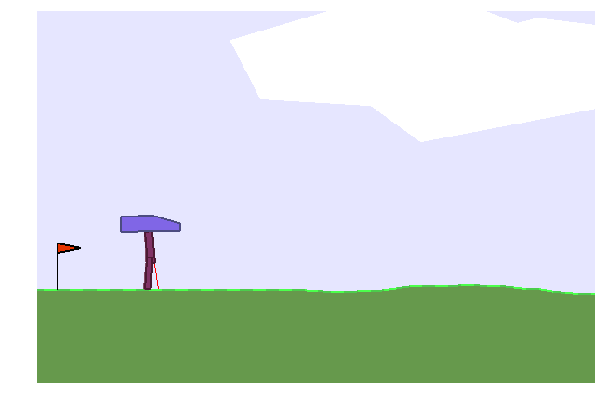

In [6]:
# Rendering the Bipedal Walker environment.

img = env.render(mode='rgb_array')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
env.action_space

Box(4,)

According to OpenAI Gym's documentation, the action space in this case is an array of 4 continuous values from -1 to 1. They represent the torques the agent can apply on its joints.

Let's run the environment with random actions and see what the environment looks like when the episode finishes. After running the code below, we see that the episode ends when the walker falls.

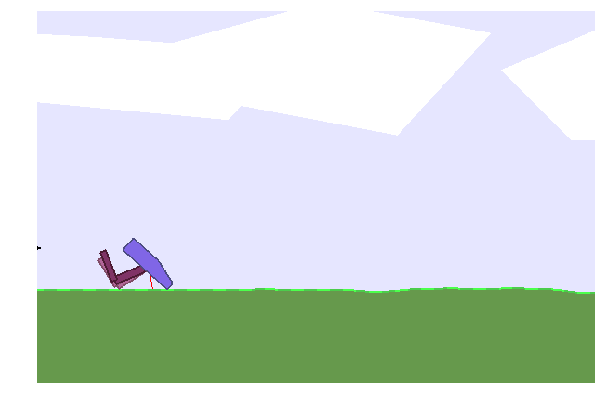

In [8]:
obs = env.reset()

for _ in range(100):
  obs, reward, done, info = env.step(env.action_space.sample())
  if done:
    break

img = env.render(mode='rgb_array')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

Before training the neural network using policy gradients, let's plot the animation of a random policy.

In [0]:
# Setting up to plot animations.

from IPython.display import HTML

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
  plt.close()
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                 frames=len(frames), repeat=repeat,
                                 interval=interval)
  return HTML(anim.to_html5_video())

In [0]:
# Running an episode with a randomized policy.

frames = []
n_max_steps = 1000

obs = env.reset()
for _ in range(n_max_steps):
  obs, reward, done, info = env.step(env.action_space.sample())
  frames.append(env.render(mode='rgb_array'))
  if done:
    break

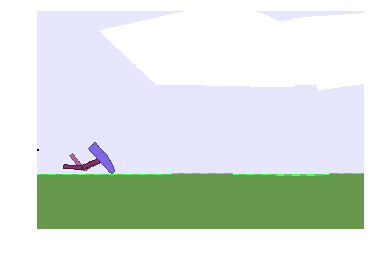

In [14]:
plot_animation(frames)

Now let's start training a neural network using policy gradients. Unlike the example in `ReinforcementLearning.ipynb` which had a discrete action space, this environment has a continuous action space. In order to deal with the continuous action space, let's discretize it.

In [0]:
from itertools import product

possible_torques = np.array([-1.0, 0.0, 1.0])
possible_actions = np.array(list(product(*(4 * (possible_torques,)))))

In [11]:
# There are 84 possible actions, one for each combination of -1, 0, and 1 for
# all 4 values for each action.

possible_actions.shape

(81, 4)

In [0]:
from functools import partial

reset_graph()
obs = env.reset()

n_inputs = obs.shape[0]
n_hidden = 100
n_actions = len(possible_actions)

learning_rate = 1e-2

he_init = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

dense = partial(tf.layers.dense, kernel_initializer=he_init,
                activation=tf.nn.relu)

hidden = dense(X, n_hidden)
logits = dense(hidden, n_actions, activation=None)
outputs = tf.nn.softmax(logits)

action_idx = tf.squeeze(tf.multinomial(tf.log(outputs), num_samples=1),
                        axis=-1)
# The target probabilities is 1 for the index of the chosen action.
y = tf.one_hot(action_idx, depth=n_actions)

xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)

grads_and_vars = optimizer.compute_gradients(xentropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
  gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
  gradient_placeholders.append(gradient_placeholder)
  grads_and_vars_feed.append((gradient_placeholder, variable))
  
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
# Defining functions for getting the discounted rewards.

def get_discount_rewards(rewards, discount_rate):
  """Compute the cumulative rewards of actions based on their current reward
  and the reward that future actions will bring.

  We multiply future actions by a "discount rate" so that the more short term
  rewards are more valuable than eventual long term rewards.
  
  """
  cumulative_rewards = [None] * len(rewards)
  cumulative_reward = 0.0
  for idx, reward in reversed(list(enumerate(rewards))):
    cumulative_reward = reward + (discount_rate * cumulative_reward)
    cumulative_rewards[idx] = cumulative_reward
  return cumulative_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
  all_discounted_rewards = \
      [get_discount_rewards(rewards, discount_rate) for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = np.mean(flat_rewards)
  reward_stddev = np.std(flat_rewards)
  return [(rewards - reward_mean) / reward_stddev
          for rewards in all_discounted_rewards]

In [0]:
# Mounting Google Drive to store the model checkpoint data even if we lose
# the kernel.

from google.colab import drive

drive.mount('/content/gdrive/')
checkpoint_path = '/content/gdrive/My Drive/models/bipedal_walker.ckpt'

In [0]:
# Train the model to teach the agent to walk.

n_games_per_update = 25
n_max_steps = 1000
n_iterations = 1000
save_iterations = 10
discount_rate = 0.99

with tf.Session() as sess:
  init.run()
  for iteration in range(n_iterations):
    print('\rIteration {}'.format(iteration), end='')
    all_rewards = []
    all_gradients = []
    for game in range(n_games_per_update):
      current_rewards = []
      current_gradients = []
      obs = env.reset()
      for step in range(n_max_steps):
        action_val, gradients_val = sess.run([action_idx, gradients],
                                             feed_dict={
                                                 X: obs.reshape(1, n_inputs),
                                             })
        obs, reward, done, info = env.step(possible_actions[action_val[0]])
        current_rewards.append(reward)
        current_gradients.append(gradients_val)
        if done:
          break
      all_rewards.append(current_rewards)
      all_gradients.append(current_gradients)
      
    all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    feed_dict = dict()
    for var_idx, gradient_placeholder in enumerate(gradient_placeholders):
      mean_gradients = np.mean([reward * all_gradients[game_idx][step][var_idx]
                                for game_idx, rewards in enumerate(all_rewards)
                                for step, reward in enumerate(rewards)],
                               axis=0)
      feed_dict[gradient_placeholder] = mean_gradients
    sess.run(training_op, feed_dict=feed_dict)
    if iteration % save_iterations == 0:
      saver.save(sess, checkpoint_path)
  saver.save(sess, checkpoint_path)

In [0]:
# Playing the game with the trained model to see how it does.

n_max_steps = 1000
frames = []

with tf.Session() as sess:
  saver.restore(sess, checkpoint_path)
  obs = env.reset()
  for _ in range(n_max_steps):
    action_idx_val = sess.run(action_idx,
                              feed_dict={X: obs.reshape(1, n_inputs)})
    action = possible_actions[action_idx_val[0]]
    obs, reward, done, info = env.step(action)
    frames.append(env.render(mode='rgb_array'))
    if done:
      break

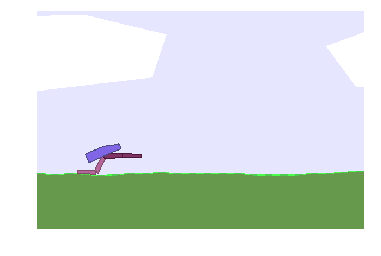

In [18]:
# Plot the animation. As we can see the model learned to stay upright by using
# the back leg as support and then inches forward using the front leg. Not
# quite what we expected but it is able to last 1000 frames without falling.

plot_animation(frames)